<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="45%" align="right" border="4">

# Quite Complex Portfolios 

This part illustrates that you can **model, value and risk manage quite complex derivatives portfolios** with DX Analytics.

In [1]:
from dx import *
import time
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline
np.random.seed(10000)

## Multiple Risk Factors

The example is based on a **multiple, correlated risk factors**, all (for the ease of exposition) `geometric_brownian_motion` objects.

In [2]:
mer = market_environment(name='me', pricing_date=dt.datetime(2015, 1, 1))
mer.add_constant('initial_value', 0.01)
mer.add_constant('volatility', 0.1)
mer.add_constant('kappa', 2.0)
mer.add_constant('theta', 0.05)
mer.add_constant('paths', 100) # dummy
mer.add_constant('frequency', 'M') # dummy
mer.add_constant('starting_date', mer.pricing_date)
mer.add_constant('final_date', dt.datetime(2015, 12, 31)) # dummy
ssr = stochastic_short_rate('ssr', mer)

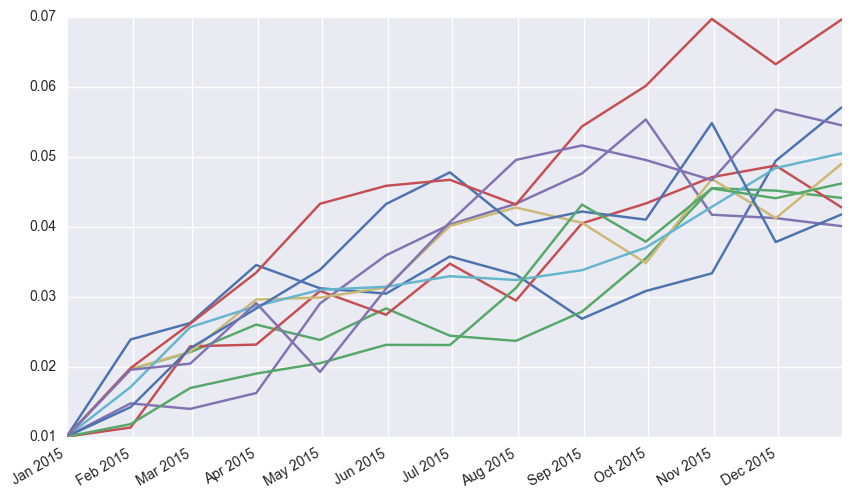

In [3]:
plt.figure(figsize=(10, 6))
plt.plot(ssr.process.time_grid, ssr.process.get_instrument_values()[:, :10]);
plt.gcf().autofmt_xdate()

In [4]:
# market environments
me = market_environment('gbm', dt.datetime(2015, 1, 1))

In [5]:
# geometric Brownian motion
me.add_constant('initial_value', 36.)
me.add_constant('volatility', 0.2) 
me.add_constant('currency', 'EUR')

In [6]:
# jump diffusion
me.add_constant('lambda', 0.4)
me.add_constant('mu', -0.4) 
me.add_constant('delta', 0.2)

In [7]:
# stochastic volatility
me.add_constant('kappa', 2.0)
me.add_constant('theta', 0.3) 
me.add_constant('vol_vol', 0.5)
me.add_constant('rho', -0.5)

Using 2,500 paths and monthly discretization for the example.

In [8]:
# valuation environment
val_env = market_environment('val_env', dt.datetime(2015, 1, 1))
val_env.add_constant('paths', 1000)
val_env.add_constant('frequency', 'M')
val_env.add_curve('discount_curve', ssr)
val_env.add_constant('starting_date', dt.datetime(2015, 1, 1))
val_env.add_constant('final_date', dt.datetime(2016, 12, 31))

In [9]:
# add valuation environment to market environments
me.add_environment(val_env)

In [10]:
no = 50  # 50 different risk factors in total

In [11]:
risk_factors = {}
for rf in range(no):
    # random model choice
    sm = np.random.choice(['gbm', 'jd', 'sv'])
    key = '%3d_%s' % (rf + 1, sm)
    risk_factors[key] = market_environment(key, me.pricing_date)
    risk_factors[key].add_environment(me)
    # random initial_value
    risk_factors[key].add_constant('initial_value',
                                    np.random.random() * 40. + 20.)
    # radnom volatility
    risk_factors[key].add_constant('volatility',
                                    np.random.random() * 0.6 + 0.05)
    # the simulation model to choose
    risk_factors[key].add_constant('model', sm)

In [12]:
correlations = []
keys = sorted(risk_factors.keys())
for key in keys[1:]:
    correlations.append([keys[0], key, np.random.choice([-0.1, 0.0, 0.1])])
correlations[:3]

[['  1_sv', '  2_gbm', 0.10000000000000001],
 ['  1_sv', '  3_gbm', -0.10000000000000001],
 ['  1_sv', '  4_gbm', -0.10000000000000001]]

## Options Modeling

We model a certain number of **derivative instruments** with the following major assumptions.

In [13]:
me_option = market_environment('option', me.pricing_date)
# choose from a set of maturity dates (month ends)
maturities = pd.date_range(start=me.pricing_date,
                           end=val_env.get_constant('final_date'),
                           freq='M').to_pydatetime()
me_option.add_constant('maturity', np.random.choice(maturities))
me_option.add_constant('currency', 'EUR')
me_option.add_environment(val_env)

## Portfolio Modeling

The `derivatives_portfolio` object we compose consists of **multiple derivatives positions**. Each option differs with respect to the strike and the risk factor it is dependent on.

In [14]:
# 5 times the number of risk factors
# as portfolio positions/instruments
pos = 5 * no              

In [15]:
positions = {}
for i in range(pos):
    ot = np.random.choice(['am_put', 'eur_call'])
    if ot == 'am_put':
        otype = 'American single'
        payoff_func = 'np.maximum(%5.3f - instrument_values, 0)'
    else:
        otype = 'European single'
        payoff_func = 'np.maximum(maturity_value - %5.3f, 0)'
    # random strike
    strike = np.random.randint(36, 40)
    underlying = sorted(risk_factors.keys())[(i + no) % no]
    name = '%d_option_pos_%d' % (i, strike)
    positions[name] = derivatives_position(
                        name=name,
                        quantity=np.random.randint(1, 10),
                        underlyings=[underlying],
                        mar_env=me_option,
                        otype=otype,
        payoff_func=payoff_func % strike)

In [16]:
# number of derivatives positions
len(positions)

250

## Portfolio Valuation

First, the derivatives portfolio with **sequential valuation**.

In [17]:
port = derivatives_portfolio(
                name='portfolio',
                positions=positions,
                val_env=val_env,
                risk_factors=risk_factors,
                correlations=correlations,
                parallel=False)  # sequential calculation

In [18]:
port.val_env.get_list('cholesky_matrix')

array([[ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.1       ,  0.99498744,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.1       ,  0.01005038,  0.99493668, ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [-0.1       ,  0.01005038, -0.01015242, ...,  0.99239533,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.1       , -0.01005038,  0.01015242, ...,  0.01526762,
         0.        ,  0.99227788]])

The call of the `get_values` method to **value all instruments**.

In [19]:
%time res = port.get_statistics(fixed_seed=True)

Totals
 pos_value    10400.2920
pos_delta      116.0584
pos_vega      8477.9800
dtype: float64
CPU times: user 17.8 s, sys: 1.53 s, total: 19.3 s
Wall time: 13.9 s


In [20]:
res.set_index('position', inplace=False)

,name,quantity,otype,risk_facts,value,currency,pos_value,pos_delta,pos_vega
position,,,,,,,,,
6_option_pos_36,6_option_pos_36,9,European single,[ 7_jd],17.651,EUR,158.859,7.9128,41.3010
178_option_pos_38,178_option_pos_38,3,European single,[ 29_jd],24.760,EUR,74.280,2.5620,40.4946
225_option_pos_39,225_option_pos_39,2,European single,[ 26_gbm],23.994,EUR,47.988,1.6648,25.6842
206_option_pos_36,206_option_pos_36,2,European single,[ 7_jd],17.651,EUR,35.302,1.7584,9.1780
67_option_pos_38,67_option_pos_38,7,European single,[ 18_sv],14.319,EUR,100.233,5.4936,6.3819
210_option_pos_37,210_option_pos_37,9,European single,[ 11_jd],13.708,EUR,123.372,7.4493,70.9308
9_option_pos_39,9_option_pos_39,7,American single,[ 10_sv],9.945,EUR,69.615,-3.2571,-1.2845
220_option_pos_38,220_option_pos_38,8,European single,[ 21_sv],15.606,EUR,124.848,6.3080,27.5824
163_option_pos_37,163_option_pos_37,5,European single,[ 14_jd],21.096,EUR,105.480,4.0555,39.5990


## Risk Analysis

**Full distribution of portfolio present values** illustrated via histogram.

In [21]:
%time pvs = port.get_present_values()

CPU times: user 4.39 s, sys: 411 ms, total: 4.8 s
Wall time: 3.3 s


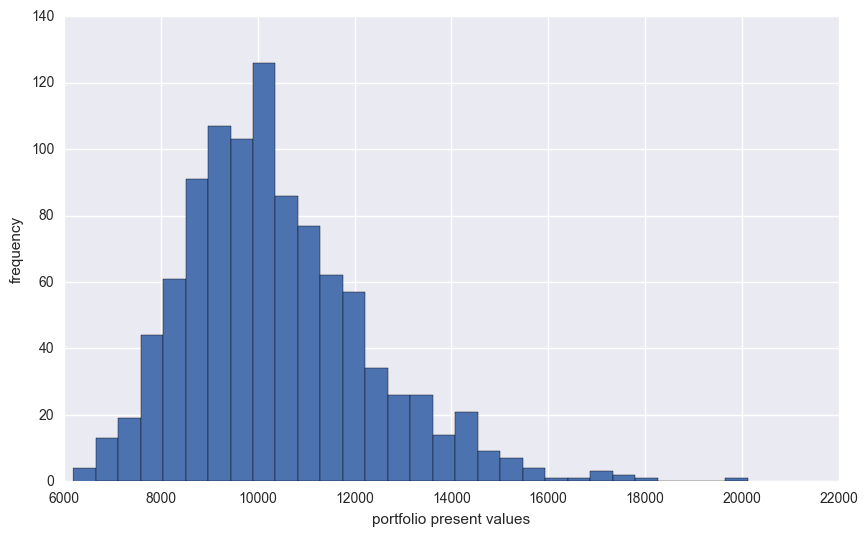

In [22]:
plt.figure(figsize=(10, 6))
plt.hist(pvs, bins=30);
plt.xlabel('portfolio present values')
plt.ylabel('frequency')

Some **statistics** via pandas.

In [23]:
pdf = pd.DataFrame(pvs)
pdf.describe()

,0
count,1000.000000
mean,10376.847033
std,1903.571223
min,6190.023925
25%,9025.700278
50%,10106.149710
75%,11403.859832
max,20116.209458


The **delta** risk report.

In [24]:
%%time
deltas, benchmark = port.get_port_risk(Greek='Delta', fixed_seed=True, step=0.2,
                                       risk_factors=list(risk_factors.keys())[:4])
risk_report(deltas)


 27_jd
0.8
1.0
1.2

 37_jd
0.8
1.0
1.2

 50_gbm
0.8
1.0
1.2

 29_jd
0.8
1.0
1.2




 27_jd_Delta
             0.8       1.0       1.2
factor     31.48     39.35     47.22
value   10303.86  10376.83  10481.86

 29_jd_Delta
             0.8       1.0       1.2
factor     46.95     58.69     70.42
value   10116.60  10376.83  10650.81

 37_jd_Delta
             0.8       1.0       1.2
factor     24.36     30.45     36.54
value   10413.17  10376.83  10387.56

 50_gbm_Delta
             0.8       1.0       1.2
factor     30.64     38.30     45.95
value   10392.87  10376.83  10401.28
CPU times: user 5.09 s, sys: 501 ms, total: 5.59 s
Wall time: 3.84 s


The **vega** risk report.

In [25]:
%%time
vegas, benchmark = port.get_port_risk(Greek='Vega', fixed_seed=True, step=0.2,
                                      risk_factors=list(risk_factors.keys())[:3])
risk_report(vegas)


 27_jd
0.8
1.0
1.2

 37_jd
0.8
1.0
1.2

 50_gbm
0.8
1.0
1.2




 27_jd_Vega
             0.8       1.0       1.2
factor      0.11      0.13      0.16
value   10381.41  10381.86  10386.49

 37_jd_Vega
             0.8       1.0       1.2
factor      0.06      0.08      0.10
value   10380.26  10381.86  10384.05

 50_gbm_Vega
             0.8       1.0       1.2
factor      0.29      0.36      0.43
value   10351.66  10381.86  10411.33
CPU times: user 4.86 s, sys: 445 ms, total: 5.3 s
Wall time: 3.68 s


## Visualization of Results

Selected **results visualized**.

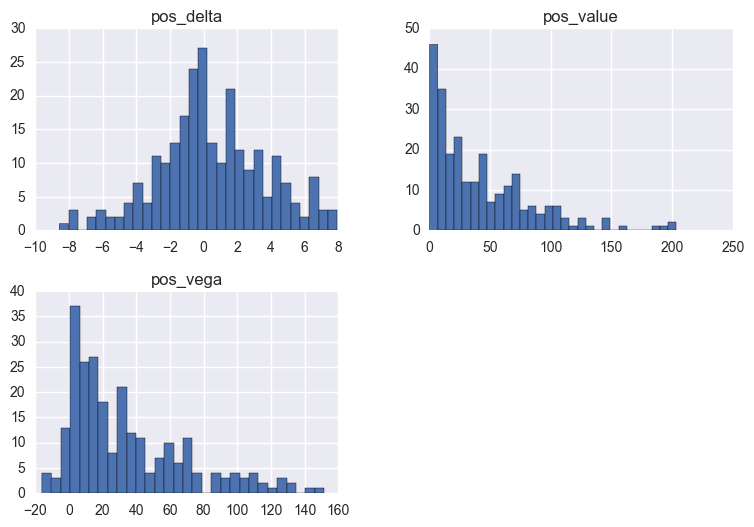

In [26]:
res[['pos_value', 'pos_delta', 'pos_vega']].hist(bins=30, figsize=(9, 6))
plt.ylabel('frequency')

**Sample paths** for three underlyings.

In [27]:
paths_0 = list(port.underlying_objects.values())[0]
paths_0.generate_paths()
paths_1 = list(port.underlying_objects.values())[1]
paths_1.generate_paths()
paths_2 = list(port.underlying_objects.values())[2]
paths_2.generate_paths()

Paths for  27_jd (blue)
Paths for  37_jd (red)
Paths for  50_gbm (green)


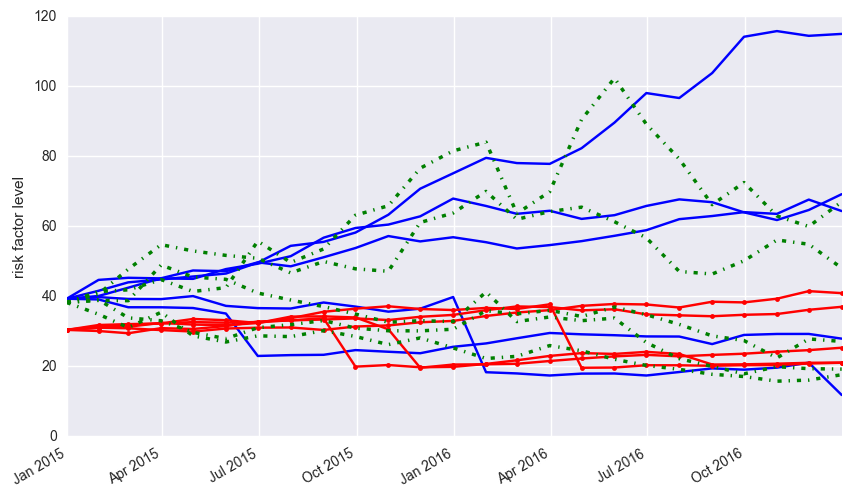

In [28]:
pa = 5
plt.figure(figsize=(10, 6))
plt.plot(port.time_grid, paths_0.instrument_values[:, :pa], 'b');
print('Paths for %s (blue)' % paths_0.name)
plt.plot(port.time_grid, paths_1.instrument_values[:, :pa], 'r.-');
print ('Paths for %s (red)' % paths_1.name)
plt.plot(port.time_grid, paths_2.instrument_values[:, :pa], 'g-.', lw=2.5);
print('Paths for %s (green)' % paths_2.name)
plt.ylabel('risk factor level')
plt.gcf().autofmt_xdate()

**Copyright, License & Disclaimer**

&copy; Dr. Yves J. Hilpisch | The Python Quants GmbH

DX Analytics (the "dx library") is licensed under the GNU Affero General Public License
version 3 or later (see [http://www.gnu.org/licenses/](http://www.gnu.org/licenses/)).

DX Analytics comes with no representations
or warranties, to the extent permitted by applicable law.


<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

[http://tpq.io](http://tpq.io) | [team@tpq.io](mailto:team@tpq.io) | [http://twitter.com/dyjh](http://twitter.com/dyjh)

**Quant Platform** |
[http://quant-platform.com](http://quant-platform.com)

**Derivatives Analytics with Python (Wiley Finance)** |
[http://derivatives-analytics-with-python.com](http://derivatives-analytics-with-python.com)

**Python for Finance (O'Reilly)** |
[http://python-for-finance.com](http://python-for-finance.com)